In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import plotly.graph_objects as go
import joblib
import investpy
from datetime import datetime, timedelta
print("DONE")

DONE


In [2]:
search_result = investpy.search_quotes(
    text='MBSB',
    products=['stocks'],
    countries=['malaysia'],
    n_results=1
)

ticker = search_result.symbol
print(search_result)

{"id_": 41608, "name": "MBSB Bhd", "symbol": "MBSB", "country": "malaysia", "tag": "/equities/malaysia-building-society-bhd", "pair_type": "stocks", "exchange": "Kuala Lumpur"}


In [3]:
today = datetime.today().strftime('%d/%m/%Y')
one_year_ago = (datetime.today() - timedelta(days=365)).strftime('%d/%m/%Y')

data1D = search_result.retrieve_historical_data(
    from_date=one_year_ago,
    to_date=today
)

print(data1D.tail())

             Open   High    Low  Close   Volume  Change Pct
Date                                                       
2025-09-26  0.745  0.750  0.740  0.750  5188000        0.67
2025-09-29  0.750  0.755  0.740  0.750  7132200        0.00
2025-09-30  0.750  0.755  0.735  0.735  7414500       -2.00
2025-10-01  0.740  0.750  0.740  0.745  5103400        1.36
2025-10-02  0.750  0.760  0.750  0.755  7805100        1.34


In [4]:
# ticker = "1171.KL"
# data1D = yf.download(ticker, period="1y", interval="1d")
# print(data1D.head())

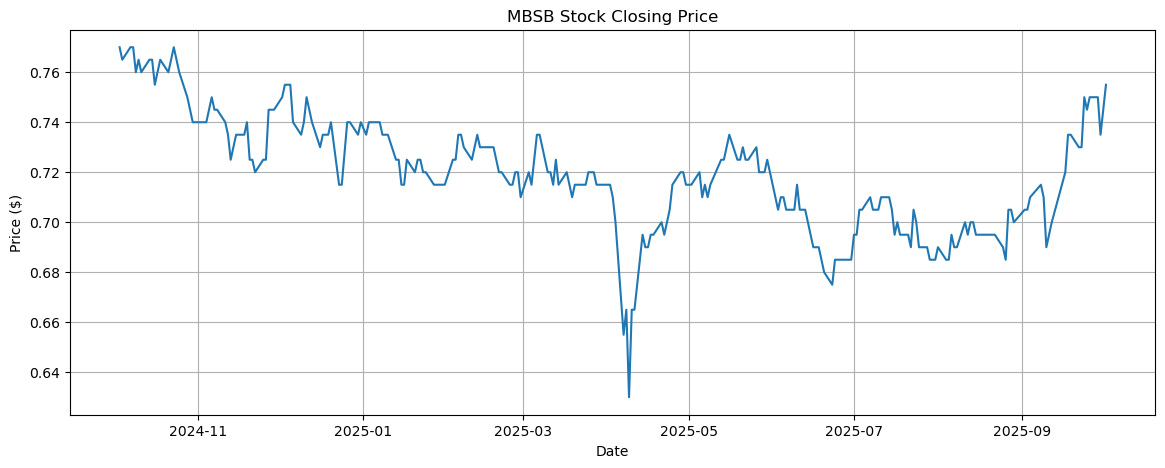

In [5]:
plt.figure(figsize=(14, 5))
plt.plot(data1D['Close'])
plt.title(f'{ticker} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

In [6]:
close_prices = data1D['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

print(f"Original price range: ${close_prices.min():.2f} - ${close_prices.max():.2f}")
print(f"Scaled data range: {scaled_data.min():.4f} - {scaled_data.max():.4f}")

Original price range: $0.63 - $0.77
Scaled data range: 0.0000 - 1.0000


In [7]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)
X = X.reshape(X.shape[0], X.shape[1], 1)
print(f"X shape: {X.shape} (samples, time_steps, features)")
print(f"y shape: {y.shape} (samples,)")

X shape: (184, 60, 1) (samples, time_steps, features)
y shape: (184,) (samples,)


In [8]:
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 147
Testing samples: 37


In [9]:
models = keras.models
layers = keras.layers
callbacks = keras.callbacks

model = models.Sequential([
    # First LSTM layer with dropout
    layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.Dropout(0.2),
    
    # Second LSTM layer
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),
    
    # Third LSTM layer
    layers.LSTM(units=50, return_sequences=False),
    layers.Dropout(0.2),
    
    # Output layer
    layers.Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
print("✅ Model built successfully!")
model.summary()

✅ Model built successfully!


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
print("Training model without early stopping")

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

print("Training complete")

Training model without early stopping
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.2452 - val_loss: 0.0880
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0401 - val_loss: 0.0163
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0326 - val_loss: 0.0549
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0326 - val_loss: 0.0390
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0205 - val_loss: 0.0150
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0247 - val_loss: 0.0166
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0195 - val_loss: 0.0320
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0188 - val_loss: 0.0274
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0181 - val_loss: 0.0174
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0201 - val_loss: 0.0173
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0150 - val_loss: 0.0235
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━

In [11]:
print("Training model with early stopping")

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

print("Training complete!")

Training model with early stopping
Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0105 - val_loss: 0.0079
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0101 - val_loss: 0.0090
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0093 - val_loss: 0.0077
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0092 - val_loss: 0.0103
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0097 - val_loss: 0.0079
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0103 - val_loss: 0.0080
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0

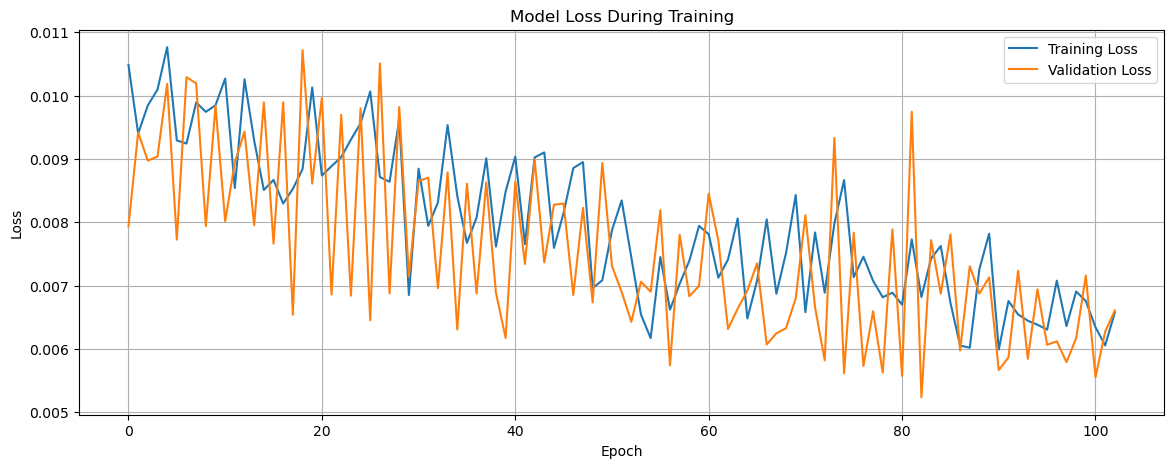

In [12]:
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"Sample predictions:")
for i in range(5):
    print(f"  Actual: ${y_test_actual[i][0]:.2f} | Predicted: ${predictions[i][0]:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Sample predictions:
  Actual: $0.69 | Predicted: $0.69
  Actual: $0.69 | Predicted: $0.69
  Actual: $0.70 | Predicted: $0.70
  Actual: $0.69 | Predicted: $0.70
  Actual: $0.70 | Predicted: $0.70


In [14]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=y_test_actual.flatten(), mode='lines', name='Actual', line=dict(color='blue')))

fig.add_trace(go.Scatter(y=predictions.flatten(), mode='lines', name='Predicted', line=dict(color='red')))

fig.update_layout(
    title=f'{ticker} Stock Price Prediction',
    xaxis_title='Days',
    yaxis_title='Price ($)',
    template='plotly_white'
)

fig.show()

In [ ]:
model.save('stock_model.keras')
model.save('stock_model.h5')
print("Model saved")

joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved")

Model saved'
Scaler saved


In [16]:
def predict_future(model, last_sequence, days):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days):
        next_pred = model.predict(current_sequence.reshape(1, sequence_length, 1), verbose=0)
        predictions.append(next_pred[0, 0])
        current_sequence = np.append(current_sequence[1:], next_pred)
    
    return np.array(predictions)

last_60_days = scaled_data[-sequence_length:]

future_predictions = predict_future(model, last_60_days, 5)
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

print("\nNext 5 Days Predictions:")
for i, pred in enumerate(future_predictions, 1):
    print(f"Day {i}: ${pred[0]:.2f}")


Next 5 Days Predictions:
Day 1: $0.74
Day 2: $0.75
Day 3: $0.75
Day 4: $0.74
Day 5: $0.74


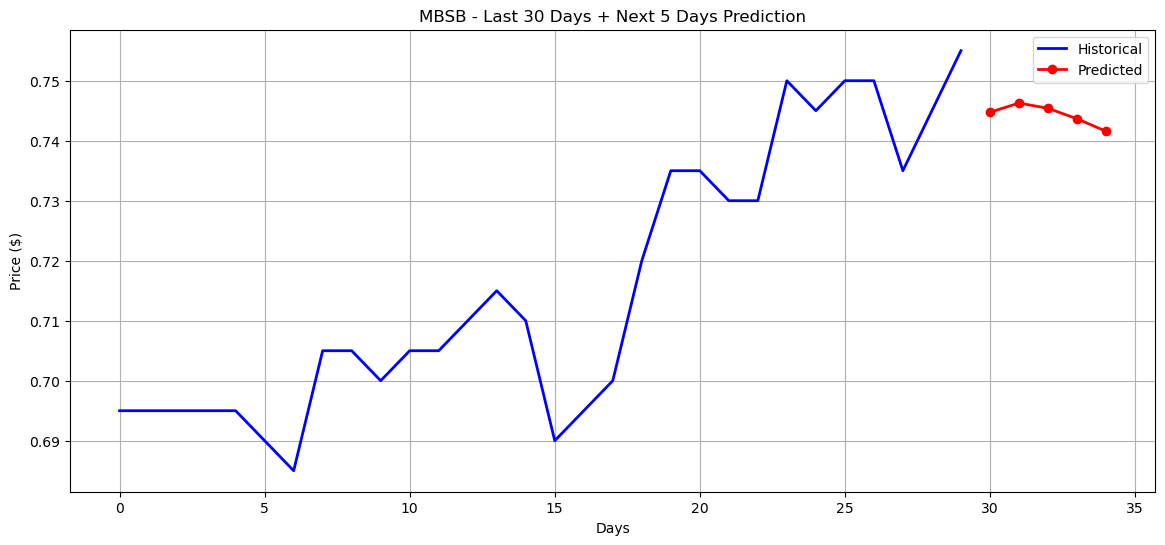

In [17]:
plt.figure(figsize=(14, 6))
historical = close_prices[-30:]  # Last 30 days
plt.plot(range(len(historical)), historical, label='Historical', color='blue', linewidth=2)
plt.plot(range(len(historical), len(historical) + 5), future_predictions, 
         label='Predicted', color='red', linewidth=2, marker='o')
plt.title(f'{ticker} - Last 30 Days + Next 5 Days Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()